# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;HACETTEPE UNIVERSITY COMPUTER ENGINEERING
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;BBM 409 Machine Learning Lab
## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;Assignmet III

### &emsp;Name/Surname: Oktay UĞURLU
### &emsp;School Number: 21627725
### &emsp;E-mail: b21627725@cs.hacettepe.edu.tr

# Part I: Classification of Natural Scenes using Neural Network

In this assignment, the aim is implementing the single layer and multilayer neural networks to predict 6 scene classes.

**Note:** You can run the train.py and test.py by giving these commands:
- python train.py -data path < trained_data_path >
- python test.py -data path < tested_data_path > -data path < weigths >

## 1. Dataset

In [5]:
pip install opencv-python

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires h5py~=2.10.0, which is not installed.
tensorboard 2.5.0 requires werkzeug>=0.11.15, which is not installed.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.20.2 which is incompatible.


In [23]:
import cv2
import pandas as pd
from math import log
import numpy as np
import matplotlib.pyplot as plt
import operator
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt                              #For visualization

from os import listdir, system
from random import random
from sklearn.metrics import accuracy_score

In [24]:
from sklearn.preprocessing import normalize

In [25]:
SIZE=30
TRAIN_DATA_SIZE=14034
TEST_DATA_SIZE=3650
TEST_DATA_SIZE=3000

We have read the train data to do grayscaling, resizing, and vectorizing operations.

In [26]:
#Reading train data
train_image_df = pd.DataFrame(columns=["id", "image", "class name"])

for class_name in listdir('./dataset/seg_train/seg_train'):
    for image_name in listdir('./dataset/seg_train/seg_train/'+class_name):
        img = cv2.imread('./dataset/seg_train/seg_train/'+class_name+'/'+image_name, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        resized_image = cv2.resize(img, (SIZE, SIZE)) #Resizing image to 30x30
        resized_image /= 255.0   # Normalization
        resized_image = resized_image.reshape(1, SIZE*SIZE) #Vectorizing
        train_image_df = train_image_df.append(pd.DataFrame([[int(image_name.split(".")[0]),resized_image,class_name]],columns=["id", "image", "class name"]), ignore_index=True)

train_image_df.reset_index(drop=True)
train_image_df.index = train_image_df["id"]
# Normalize class names as integer value
train_image_df["class name"] = train_image_df["class name"].map(lambda x:0 if x=="buildings" else 1 if x=="forest" else 2 if x=="glacier" else 3 if x=="mountain" else 4 if x=="sea" else 5 if x=="street" else x)

train_image_df = train_image_df.sample(frac=1,random_state=3)

We will use validaiton dataset to find optimum hyperparameters.

In [1450]:
#Reading dev data
train_dev_df = pd.DataFrame(columns=["id", "image", "class name"])

for class_name in listdir('./dataset/seg_dev/seg_dev'):
    for image_name in listdir('./dataset/seg_dev/seg_dev/'+class_name):
        img = cv2.imread('./dataset/seg_dev/seg_dev/'+class_name+'/'+image_name, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        resized_image = cv2.resize(img, (SIZE, SIZE)) #Resizing image to 30x30
        resized_image /= 255.0   # Normalization
        resized_image = resized_image.reshape(1, SIZE*SIZE) #Vectorizing
        train_dev_df = train_dev_df.append(pd.DataFrame([[int(image_name.split(".")[0]),resized_image,class_name]],columns=["id", "image", "class name"]), ignore_index=True)

train_dev_df.reset_index(drop=True)
train_dev_df.index = train_dev_df["id"]

# Normalize class names as integer value
train_dev_df["class name"] = train_dev_df["class name"].map(lambda x:0 if x=="buildings" else 1 if x=="forest" else 2 if x=="glacier" else 3 if x=="mountain" else 4 if x=="sea" else 5 if x=="street" else x)
train_dev_df = train_dev_df.sample(frac=1,random_state=3)

You can see an example for transformed image:

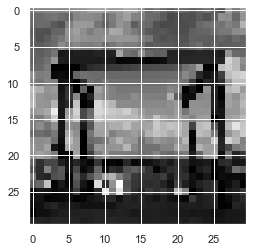

In [865]:
plt.imshow(train_image_df["image"][1].reshape(SIZE, SIZE), cmap='gray')

## 2. Single Layer Neural Network

In the implementation part, I have initialize all weights with 0.001, because when I initialize randomly, after second epoch, all the model weights decreased near to zero. 

In implementation, I have used 2 different objective function and 3 different activation functions:

- Sigmoid function and mean square error
- Softmax function and negative log likelihood
- ReLu and negative log likelihood

In [71]:
class Single_Neural_Network:
    def __init__(self, is_sigmoid=False, is_softmax=False, is_tanh=False, is_relu=False, is_mse=False, is_neg_log_likelihood=False ):
        #activation function
        self.is_sigmoid = is_sigmoid
        self.is_softmax = is_softmax
        self.is_tanh = is_tanh
        self.is_relu = is_relu
        
        #objective function
        self.is_mse = is_mse
        self.is_neg_log_likelihood = is_neg_log_likelihood
        
        self.prediction_list=[]
        self.all_epoch_loss_list = []
        
        # weight initialization
        self.weights=np.zeros((6,900))
        for i in range(0,self.weights.shape[0]):
            for j in range(0,self.weights.shape[1]):
                self.weights[i][j] = 0.001
        self.errors=np.zeros((self.weights.shape[0]))
    def __softmax_function(self, output_list): #returns softmax for all output for each train data 
        return np.exp(output_list) / np.sum(np.exp(output_list))
    
    def __der_softmax_function(self, output_list): #returns softmax derivation by input
        gradient=np.zeros((self.weights.shape[0],self.weights.shape[0]))
        for i in range(0,gradient.shape[0]):
            for j in range(0,gradient.shape[0]):
                if i == j:
                    gradient[i][j] = output_list[i] * (1-output_list[i])
                else: 
                    gradient[i][j] = -output_list[i] * output_list[j]
        return gradient
    
    def __forwarding(self, inputs, output_neuron):
        if self.is_sigmoid == True:
            input_for_activation = np.dot(inputs, self.weights[output_neuron])
            return 1/(1+np.exp(-input_for_activation))
        if self.is_softmax == True:
            input_for_softmax_arr = np.dot(inputs, self.weights.T)
            return np.exp(input_for_softmax_arr[output_neuron]) / np.sum(np.exp(input_for_softmax_arr)) # result is (1,output neuron size)
        if self.is_relu == True:   
            input_for_softmax_arr = np.dot(inputs, self.weights.T)
            input_for_softmax_arr[input_for_softmax_arr<=0]=0
            return input_for_softmax_arr[output_neuron]
        else:
            return []    
    def train(self, train_data_df, LEARNING_RATE=0.005, batch_size=1):
        
        # We create weights for each output neuron. Each row indicates weights links to the each output neuron
        output_neuron_size = train_data_df["class name"].unique().shape[0]
        number_of_weights = train_data_df["image"][0].shape[1]
        classes1 = train_data_df["class name"].unique()
        classes2 = train_data_df["class name"].unique()
        classes1.sort()
        classes2.sort()
        
        loss_list = []
        
        #mini batch variables
        new_weights = np.zeros((output_neuron_size, number_of_weights))
        batch_counter=1
        self.batch_size=batch_size
        
        for id_value in train_data_df["id"]: # We update each weights seperately by output neurons.
            
            class_name = train_data_df.loc[id_value]["class name"]
            input_neurons = train_data_df.loc[id_value]["image"][0]
                
            #This gives the true y values of output neurons
            
            expected_output_array = np.zeros((1, output_neuron_size))[0]
            expected_output_array[class_name] = 1
            outputs = np.zeros((self.weights.shape[0]))
            
            #Calculate forward for each output neuron
            if self.is_sigmoid == True:
                for output_neuron in classes1:
                    input_for_activation = np.dot(input_neurons, self.weights[output_neuron])
                    outputs[output_neuron] = 1/(1+np.exp(-input_for_activation))
            if self.is_softmax == True:
                input_for_softmax_arr = np.dot(input_neurons, self.weights.T)
                outputs = self.__softmax_function(input_for_softmax_arr) # result is (1,output neuron size)
            if self.is_relu == True:   
                input_for_softmax_arr = np.dot(input_neurons, self.weights.T)
                input_for_softmax_arr[input_for_softmax_arr<=0]=0
                outputs=input_for_softmax_arr
                
            #Calculate error for each output neuron
            if self.is_mse:
                for output_n in classes2: 
                    self.errors[output_n] += expected_output_array[output_n]-outputs[output_n]

            #mini batch update
            if self.batch_size==batch_counter:
                # backward calculation
                for output_n in classes2:
                    if self.is_sigmoid and self.is_mse:
                        delta=LEARNING_RATE*(self.errors[output_n] / self.batch_size) * outputs[output_n] * (1 - outputs[output_n]) * input_neurons
                    if self.is_softmax and self.is_neg_log_likelihood:
                        delta = LEARNING_RATE * (expected_output_array[output_n]-outputs[output_n]) * input_neurons
                    if self.is_relu and self.is_mse: 
                        delta = LEARNING_RATE * (self.errors[output_n] / self.batch_size) * (0 if outputs[output_n]<0 else 1) * input_neurons
                    self.weights[output_n] += delta
                    
                batch_counter=1
                self.errors=np.zeros((self.weights.shape[0]))
            else:
                batch_counter+=1
                
            if(self.is_mse):
                loss_list.append(np.mean(np.square(expected_output_array-outputs)))
            elif(self.is_neg_log_likelihood):
                loss_list.append(-np.log(outputs[class_name]))

        if(self.is_mse):        
            self.all_epoch_loss_list.append(np.mean(loss_list))
        elif(self.is_neg_log_likelihood):
            self.all_epoch_loss_list.append(np.sum(loss_list))
        
    def predict(self, predict_data):
        self.prediction_list=[]
        output_neuron_size = predict_data["class name"].unique().shape[0]
        for id_value in predict_data["id"]:
            input_neurons = predict_data[predict_data["id"]==id_value]["image"].values[0][0]
            
            outputs = []
            #Calculate forward for each output neuron
            for output_neuron in range(0, output_neuron_size):
                outputs.append(self.__forwarding(input_neurons, output_neuron))
                
            self.prediction_list.append(outputs.index(max(outputs)))
        return self.prediction_list

### Learning Rate

We need to decide to what should we use as learning rate and epoch number. Firstly, I set epoch to 6 and try different learning rates. I also used sigmoid and mean square error:

In [1959]:

LEARNING_RATES = [0.005,0.01,0.02]

single_neural_network11 = Single_Neural_Network(is_sigmoid=True, is_mse=True)
for i in range(0,20):
    single_neural_network11.train(train_image_df, LEARNING_RATE=LEARNING_RATES[0], batch_size=1)
    print("Epoch "+str(i+1)+" with learning rate "+ str(LEARNING_RATES[0]) +": "+str(single_neural_network11.all_epoch_loss_list[i]))
    print("-------------------------------------------------------")
    
single_neural_network12 = Single_Neural_Network(is_sigmoid=True, is_mse=True)
for i in range(0,20):
    single_neural_network12.train(train_image_df, LEARNING_RATE=LEARNING_RATES[1], batch_size=1)
    print("Epoch "+str(i+1)+" with learning rate "+ str(LEARNING_RATES[1]) +": "+str(single_neural_network12.all_epoch_loss_list[i]))
    print("-------------------------------------------------------")

single_neural_network13 = Single_Neural_Network(is_sigmoid=True, is_mse=True)
for i in range(0,20):
    single_neural_network13.train(train_image_df, LEARNING_RATE=LEARNING_RATES[2], batch_size=1)
    print("Epoch "+str(i+1)+" with learning rate "+ str(LEARNING_RATES[2]) +": "+str(single_neural_network13.all_epoch_loss_list[i]))
    print("-------------------------------------------------------")
    

Epoch 1 with learning rate 0.005: 0.13336170268454875
-------------------------------------------------------
Epoch 2 with learning rate 0.005: 0.13021582982235472
-------------------------------------------------------
Epoch 3 with learning rate 0.005: 0.12938641661990224
-------------------------------------------------------
Epoch 4 with learning rate 0.005: 0.12877668861055105
-------------------------------------------------------
Epoch 5 with learning rate 0.005: 0.12825747711099458
-------------------------------------------------------
Epoch 6 with learning rate 0.005: 0.12779341066863953
-------------------------------------------------------
Epoch 7 with learning rate 0.005: 0.12736954945440343
-------------------------------------------------------
Epoch 8 with learning rate 0.005: 0.12697786734988664
-------------------------------------------------------
Epoch 9 with learning rate 0.005: 0.12661332157273816
-------------------------------------------------------
Epoch 10 w

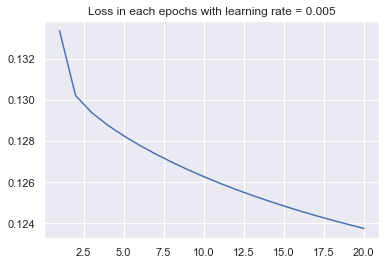

In [1960]:
epoch_list=[i for i in range(1,21)]
plt.title('Loss in each epochs with learning rate = '+str(LEARNING_RATES[0]))
plt.plot(epoch_list, single_neural_network11.all_epoch_loss_list)

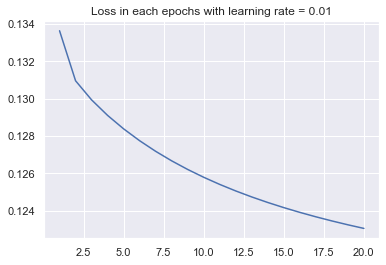

In [1961]:
plt.title('Loss in each epochs with learning rate = '+str(LEARNING_RATES[1]))
plt.plot(epoch_list, single_neural_network12.all_epoch_loss_list)

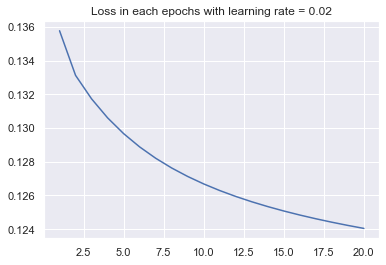

In [1962]:
plt.title('Loss in each epochs with learning rate = '+str(LEARNING_RATES[2]))
plt.plot(epoch_list, single_neural_network13.all_epoch_loss_list)

### Epoch number

When the loss values are decreased, we can say that the model is learning. In first 2 epoch, loss values of the model which trained with 0.005 learning rate is more decreased than others. So, we can select the learning rate as 0.005. After that, we can analyze the best epoch numbers. I have tried to the 50 epoch to see the cahnges at the loss result:

In [1973]:
single_neural_network14 = Single_Neural_Network(is_sigmoid=True, is_mse=True)
learning_rate=0.005
validation_acc=[]
for i in range(0,100):
    single_neural_network14.train(train_image_df, LEARNING_RATE=learning_rate, batch_size=1)
    print("Loss at epoch "+str(i+1)+": "+str(single_neural_network14.all_epoch_loss_list[i]))
    acc=accuracy_score(train_dev_df["class name"].values, single_neural_network14.predict(train_dev_df))
    print("Accuracy at epoch "+str(i+1)+": "+str(acc))
    print("-------------------------------------------------------")
    validation_acc.append(acc)

Loss at epoch 1: 0.13336170268454875
Accuracy at epoch 1: 0.35433333333333333
-------------------------------------------------------
Loss at epoch 2: 0.13021582982235472
Accuracy at epoch 2: 0.36233333333333334
-------------------------------------------------------
Loss at epoch 3: 0.12938641661990224
Accuracy at epoch 3: 0.362
-------------------------------------------------------
Loss at epoch 4: 0.12877668861055105
Accuracy at epoch 4: 0.362
-------------------------------------------------------
Loss at epoch 5: 0.12825747711099458
Accuracy at epoch 5: 0.364
-------------------------------------------------------
Loss at epoch 6: 0.12779341066863953
Accuracy at epoch 6: 0.362
-------------------------------------------------------
Loss at epoch 7: 0.12736954945440343
Accuracy at epoch 7: 0.365
-------------------------------------------------------
Loss at epoch 8: 0.12697786734988664
Accuracy at epoch 8: 0.36633333333333334
------------------------------------------------------

Accuracy at epoch 64: 0.35433333333333333
-------------------------------------------------------
Loss at epoch 65: 0.11953958102763709
Accuracy at epoch 65: 0.3536666666666667
-------------------------------------------------------
Loss at epoch 66: 0.11949412535139257
Accuracy at epoch 66: 0.3526666666666667
-------------------------------------------------------
Loss at epoch 67: 0.11944965700481483
Accuracy at epoch 67: 0.35333333333333333
-------------------------------------------------------
Loss at epoch 68: 0.11940614331106385
Accuracy at epoch 68: 0.3536666666666667
-------------------------------------------------------
Loss at epoch 69: 0.11936355298838672
Accuracy at epoch 69: 0.353
-------------------------------------------------------
Loss at epoch 70: 0.11932185614206543
Accuracy at epoch 70: 0.35333333333333333
-------------------------------------------------------
Loss at epoch 71: 0.1192810241340912
Accuracy at epoch 71: 0.35333333333333333
------------------------

If we look at the learning speed, the learning speed is decreased after 50: 

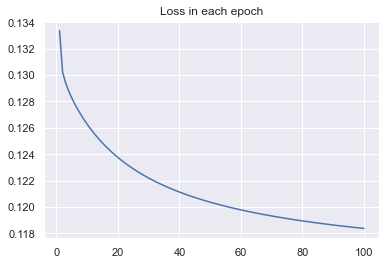

In [1974]:
arr_epoch_number = [i for i in range(1,101)]
plt.title('Loss in each epoch')
plt.plot(arr_epoch_number, single_neural_network14.all_epoch_loss_list)

Also, the accuracy is extremely decreased after 40 epoch. We can say that, the model is overfit after 40 epoch. So, we can set our epoch number is 40 for high accuracy which is ~0.36 on validation data.

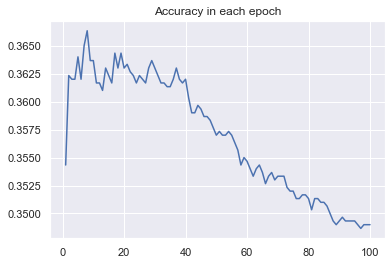

In [1978]:
arr_epoch_number = [i for i in range(1,101)]
plt.title('Accuracy in each epoch')
plt.plot(arr_epoch_number, validation_acc)

### Batch Size

Thus far, we set our learning rate as 0.005 and set our epoch as 40. We set our batch size always as 1. But, to increase the time efficiency of training operation, we need to set mini-batch size more than 1. So, we need to find optimum batch size for update frequency:

In [1982]:
learning_rate=0.005
validation_acc=[]
batch_size_list=[16,32,64,128]
for batch_size in batch_size_list:
    single_neural_network15 = Single_Neural_Network(is_sigmoid=True, is_mse=True)
    for i in range(0,40):
        single_neural_network15.train(train_image_df, LEARNING_RATE=learning_rate, batch_size=batch_size)

    print("Loss with batch size "+str(batch_size)+": "+str(single_neural_network15.all_epoch_loss_list[i]))
    acc=accuracy_score(train_dev_df["class name"].values, single_neural_network15.predict(train_dev_df))
    validation_acc.append(acc)
    print("Accuracy with batch size "+str(batch_size)+": "+str(acc))
    print("-------------------------------------------------------")

Loss with batch size 16: 0.13637059284418598
Accuracy with batch size 16: 0.2776666666666667
-------------------------------------------------------
Loss with batch size 32: 0.1409829799321674
Accuracy with batch size 32: 0.234
-------------------------------------------------------
Loss with batch size 64: 0.14266376604091613
Accuracy with batch size 64: 0.17833333333333334
-------------------------------------------------------
Loss with batch size 128: 0.1425389106207936
Accuracy with batch size 128: 0.188
-------------------------------------------------------


Because of the accuracy is decreased, I decided to set batch size as 1.

### Activation and Objective Function

We have used sigmoid function and mean square error for our model, and get accuracy as 0.36 with validation data. In this part, we will try different activation and objective function and calculate loss values with different loss function.

- **Sigmoid and mean square error**

In [2040]:
single_neural_network21 = Single_Neural_Network(is_sigmoid=True, is_mse=True)

for i in range(0,40):
    single_neural_network21.train(train_image_df, LEARNING_RATE=0.005, batch_size=1)
    print("Epoch "+str(i+1)+": "+str(single_neural_network21.all_epoch_loss_list[i]))
    acc=accuracy_score(train_dev_df["class name"].values, single_neural_network21.predict(train_dev_df))
    print("Accuracy at epoch "+str(i+1)+": "+str(acc))
    print("-------------------------------------------------------")

Epoch 1: 0.13336170268454875
Accuracy at epoch 1: 0.35433333333333333
-------------------------------------------------------
Epoch 2: 0.13021582982235472
Accuracy at epoch 2: 0.36233333333333334
-------------------------------------------------------
Epoch 3: 0.12938641661990224
Accuracy at epoch 3: 0.362
-------------------------------------------------------
Epoch 4: 0.12877668861055105
Accuracy at epoch 4: 0.362
-------------------------------------------------------
Epoch 5: 0.12825747711099458
Accuracy at epoch 5: 0.364
-------------------------------------------------------
Epoch 6: 0.12779341066863953
Accuracy at epoch 6: 0.362
-------------------------------------------------------
Epoch 7: 0.12736954945440343
Accuracy at epoch 7: 0.365
-------------------------------------------------------
Epoch 8: 0.12697786734988664
Accuracy at epoch 8: 0.36633333333333334
-------------------------------------------------------
Epoch 9: 0.12661332157273816
Accuracy at epoch 9: 0.3636666666

For sigmoid and mean square error, we get 0.362 accuracy.

- **Softmax and negative log likelihood**

In [2050]:
single_neural_network22 = Single_Neural_Network(is_softmax=True, is_neg_log_likelihood=True)

for i in range(0,40):
    single_neural_network22.train(train_image_df, LEARNING_RATE=0.005, batch_size=1)
    print("Epoch "+str(i+1)+": "+str(single_neural_network22.all_epoch_loss_list[i]))
    acc=accuracy_score(train_dev_df["class name"].values, single_neural_network22.predict(train_dev_df))
    print("Accuracy at epoch "+str(i+1)+": "+str(acc))
    print("-------------------------------------------------------")

Epoch 1: 25884.8567790583
Accuracy at epoch 1: 0.31133333333333335
-------------------------------------------------------
Epoch 2: 25127.30471789658
Accuracy at epoch 2: 0.30966666666666665
-------------------------------------------------------
Epoch 3: 24713.417138108525
Accuracy at epoch 3: 0.31266666666666665
-------------------------------------------------------
Epoch 4: 24435.571638754038
Accuracy at epoch 4: 0.316
-------------------------------------------------------
Epoch 5: 24238.208211209698
Accuracy at epoch 5: 0.31733333333333336
-------------------------------------------------------
Epoch 6: 24092.825598935793
Accuracy at epoch 6: 0.31633333333333336
-------------------------------------------------------
Epoch 7: 23982.942960511868
Accuracy at epoch 7: 0.318
-------------------------------------------------------
Epoch 8: 23898.290307889096
Accuracy at epoch 8: 0.31766666666666665
-------------------------------------------------------
Epoch 9: 23832.116316826246
Acc

We get accuracy as 0.32 after training the model with softmax and negative log likelihood.

- **ReLu and mean square error**

In [2132]:
single_neural_network23 = Single_Neural_Network(is_relu=True, is_mse=True)

for i in range(0,40):
    single_neural_network23.train(train_image_df, LEARNING_RATE=0.005, batch_size=1)
    print("Epoch "+str(i+1)+": "+str(single_neural_network23.all_epoch_loss_list[i]))
    acc=accuracy_score(train_dev_df["class name"].values, single_neural_network23.predict(train_dev_df))
    print("Accuracy at epoch "+str(i+1)+": "+str(acc))
    print("-------------------------------------------------------")

Epoch 1: 0.2187514015083314
Accuracy at epoch 1: 0.255
-------------------------------------------------------
Epoch 2: 0.21018911577417446
Accuracy at epoch 2: 0.25866666666666666
-------------------------------------------------------
Epoch 3: 0.2062543377245442
Accuracy at epoch 3: 0.25966666666666666
-------------------------------------------------------
Epoch 4: 0.20418356969038468
Accuracy at epoch 4: 0.258
-------------------------------------------------------
Epoch 5: 0.20286041472007074
Accuracy at epoch 5: 0.255
-------------------------------------------------------
Epoch 6: 0.20203264736086882
Accuracy at epoch 6: 0.24966666666666668
-------------------------------------------------------
Epoch 7: 0.20147275982862653
Accuracy at epoch 7: 0.24933333333333332
-------------------------------------------------------
Epoch 8: 0.2011015662118141
Accuracy at epoch 8: 0.25166666666666665
-------------------------------------------------------
Epoch 9: 0.20083518416637355
Accuracy

We get the most low accuracy for relu and mse used in model.

If we look at our first model, we can say that the centers of the images are more weighted in neural network. So, the importance is increased in the middle of the image.

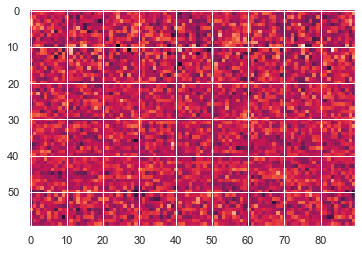

In [2136]:
import matplotlib.pyplot as plt
import numpy as np

www = single_neural_network21.weights
def plot_parameters(www, size1, size2):
    plt.figure()
    plt.imshow(www.reshape(size1,size2)) 
    plt.show() 

#Usage
plot_parameters(www,60,90)

In [2133]:
np.savetxt("weights_sigmoid_mse.csv", single_neural_network21.weights, delimiter=",")

## 3. Multi Layer Neural Network

In [108]:
class Multiple_Neural_Network:
    def __init__(self, hidden_layer_size=2,number_of_hidden_layer=1):
        self.all_epoch_loss_list = []
        
        # weight initialization
        self.weights=np.zeros((6,hidden_layer_size))
        for i in range(0,self.weights.shape[0]):
            for j in range(0,self.weights.shape[1]):
                self.weights[i][j] = 0.001
                
        self.first_layer_hidden_weights=np.zeros((hidden_layer_size,900))
        for i in range(0,self.first_layer_hidden_weights.shape[0]):
            for j in range(0,self.first_layer_hidden_weights.shape[1]):
                self.first_layer_hidden_weights[i][j] = 0.001
                
        if(number_of_hidden_layer>1) :     
            self.interval_hidden_weights=np.zeros((number_of_hidden_layer-1,hidden_layer_size,hidden_layer_size)) #shape=(each layer, inputs of this layer, output of this layer)
            for k in range(0,self.interval_hidden_weights.shape[0]):
                for i in range(0,self.interval_hidden_weights.shape[1]):
                    for j in range(0,self.interval_hidden_weights.shape[2]):
                        self.interval_hidden_weights[k][i][j] = 0.001
                
        self.errors=np.zeros((self.weights.shape[0]))
        self.hidden_layer_size=hidden_layer_size
        self.number_of_hidden_layer=number_of_hidden_layer
    
    def __forwarding(self, inputs, output_neuron):
        input_for_activation = np.dot(inputs, self.weights[output_neuron])
        return 1/(1+np.exp(-input_for_activation))
    
    
    def train(self, train_data_df, LEARNING_RATE=0.005, batch_size=1):
        
        # We create weights for each output neuron. Each row indicates weights links to the each output neuron
        output_neuron_size = train_data_df["class name"].unique().shape[0]
        number_of_weights = train_data_df["image"][0].shape[1]
        classes1 = train_data_df["class name"].unique()
        classes2 = train_data_df["class name"].unique()
        classes1.sort()
        classes2.sort()
        self.classes1 = classes1
        self.classes2 = classes2
        
        loss_list = []
        
        #mini batch variables
        new_weights = np.zeros((output_neuron_size, number_of_weights))
        batch_counter=1
        self.batch_size=batch_size
        
        for id_value in train_data_df["id"]: # We update each weights seperately by output neurons.
            
            class_name = train_data_df.loc[id_value]["class name"]
            input_neurons = train_data_df.loc[id_value]["image"][0]
                
            #This gives the true y values of output neurons
            
            expected_output_array = np.zeros((1, output_neuron_size))[0]
            expected_output_array[class_name] = 1
            outputs = np.zeros((self.weights.shape[0]))
            first_hidden_outputs = np.zeros((self.hidden_layer_size))
            if self.number_of_hidden_layer>1:
                interval_hidden_input = np.zeros((self.number_of_hidden_layer-1, self.hidden_layer_size))
            
            
            #Calculate FORWARD for first hidden layer
            input_hidden_layer=input_neurons
            for output_neuron in range(0,self.hidden_layer_size):
                input_for_activation = np.dot(input_neurons, self.first_layer_hidden_weights[output_neuron])
                first_hidden_outputs[output_neuron] = 1/(1+np.exp(-input_for_activation))
            input_hidden_layer = first_hidden_outputs
            
            #Calculate FORWARD for each neuron in each interval hidden layer
            for layer in range(0,self.number_of_hidden_layer-1):
                interval_hidden_outputs = np.zeros((self.number_of_hidden_layer-1, self.hidden_layer_size))
                interval_hidden_input[layer] = input_hidden_layer
                for output_neuron in range(0,self.interval_hidden_weights.shape[1]):
                    input_for_activation = np.dot(input_hidden_layer, self.interval_hidden_weights[layer][output_neuron])
                    interval_hidden_outputs[layer][output_neuron] = 1/(1+np.exp(-input_for_activation))
                input_hidden_layer = interval_hidden_outputs[layer]
               
            #Calculate FORWARD for each output neuron
            for output_neuron in classes1:
                input_for_activation = np.dot(input_hidden_layer, self.weights[output_neuron])
                outputs[output_neuron] = 1/(1+np.exp(-input_for_activation))
            
                
            #Calculate error for each output neuron
            for output_n in classes2: 
                self.errors[output_n] += expected_output_array[output_n]-outputs[output_n]
                    
    
            #mini batch update
            if self.batch_size==batch_counter:
                # backward calculation start with outout layer
                delta_output=np.zeros((1,self.weights.shape[0]))
                
                for output_n in classes2:
                    delta=LEARNING_RATE*(self.errors[output_n] / self.batch_size) * outputs[output_n] * (1 - outputs[output_n]) 

                    self.weights[output_n] += delta* input_hidden_layer
                    delta_output[0][output_n] = delta
                    
                # backward calculation in each interval hidden layer
                interval_hidden_delta_output=np.zeros((1,self.hidden_layer_size))
                z2_error = delta_output.dot(self.weights) [0]
                for layer in range(self.number_of_hidden_layer-2,-1,-1):
                    delta_output=np.zeros((1,self.interval_hidden_weights.shape[1]))
                    for output_neuron in range(0,self.interval_hidden_weights.shape[1]):
                        
                        input_for_activation = np.dot(interval_hidden_input[layer], self.interval_hidden_weights[layer][output_neuron])
                        delta=LEARNING_RATE*(z2_error[output_neuron]) * input_for_activation * (1 - input_for_activation) 
                        self.interval_hidden_weights[layer][output_n] += delta* interval_hidden_input[layer]
                        delta_output[0][output_n] = delta
                    z2_error = z2_error.dot(delta_output.T)
                    z2_error = z2_error.dot(self.interval_hidden_weights[layer]) [0]


                for output_neuron in range(0,self.first_layer_hidden_weights.shape[0]):
                        
                    input_for_activation = np.dot(input_neurons , self.first_layer_hidden_weights[output_neuron])
                    delta=LEARNING_RATE*(z2_error[output_neuron]) * input_for_activation * (1 - input_for_activation) 
 
                    self.first_layer_hidden_weights[output_neuron] += delta* input_neurons
                
                batch_counter=1
                self.errors=np.zeros((self.weights.shape[0]))
            else:
                batch_counter+=1
            loss_list.append(np.mean(np.square(expected_output_array-outputs)))
       
        self.all_epoch_loss_list.append(np.mean(loss_list))
        
    def predict(self, predict_data):
        self.prediction_list=[]
        output_neuron_size = predict_data["class name"].unique().shape[0]
        for id_value in predict_data["id"]:
            input_neurons = predict_data[predict_data["id"]==id_value]["image"].values[0][0]
            
            outputs = np.zeros((self.weights.shape[0]))        
            
            
            first_hidden_outputs = np.zeros((self.hidden_layer_size))
            if self.number_of_hidden_layer>1:
                interval_hidden_input = np.zeros((self.number_of_hidden_layer, self.hidden_layer_size))
            
            
            #Calculate FORWARD for first hidden layer
            input_hidden_layer=input_neurons
            for output_neuron in range(0,self.hidden_layer_size):
                input_for_activation = np.dot(input_neurons, self.first_layer_hidden_weights[output_neuron])
                first_hidden_outputs[output_neuron] = 1/(1+np.exp(-input_for_activation))
            input_hidden_layer = first_hidden_outputs
            
            #Calculate FORWARD for each neuron in each interval hidden layer
            for layer in range(0,self.number_of_hidden_layer-1):
                interval_hidden_outputs = np.zeros((self.number_of_hidden_layer-1, self.hidden_layer_size))
                interval_hidden_input[layer] = input_hidden_layer
                for output_neuron in range(0,self.interval_hidden_weights.shape[1]):
                    input_for_activation = np.dot(input_hidden_layer, self.interval_hidden_weights[layer][output_neuron])
                    interval_hidden_outputs[layer][output_neuron] = 1/(1+np.exp(-input_for_activation))
                input_hidden_layer = interval_hidden_outputs[layer]
                
            #Calculate FORWARD for each output neuron
            for output_neuron in self.classes1:
                input_for_activation = np.dot(input_hidden_layer, self.weights[output_neuron])
                outputs[output_neuron] = 1/(1+np.exp(-input_for_activation))

            
    
            outputs = outputs.tolist()
            self.prediction_list.append(outputs.index(max(outputs)))
        return self.prediction_list

In [109]:
multiple_neural_networkkk = Multiple_Neural_Network(number_of_hidden_layer=1)

In [ ]:
for i in range(0,10):
    multiple_neural_networkkk.train(train_image_df, LEARNING_RATE=1, batch_size=4)
multiple_neural_networkkk.all_epoch_loss_list

In [ ]:
aaaa = multiple_neural_networkkk.predict(df_train)

accuracy_score(train_image_df["class name"].values.tolist(), aaaa)